### LSTM for VAD prediction (norm) 02

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize



nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 


data=pd.read_csv('Emo_Bank_VAD.csv')

print(data.columns)
print('')
print(data.shape)
print(data.head())
print('')
print(data.dtypes)

[nltk_data] Downloading package punkt to /Users/stef_tse/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stef_tse/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Index(['id', 'split', 'V', 'A', 'D', 'text'], dtype='object')

(9906, 6)
                    id  split     V     A     D  \
0  110CYL068_1036_1079  train  3.00  3.00  3.20   
1  110CYL068_1079_1110   test  2.80  3.10  2.80   
2  110CYL068_1127_1130  train  3.00  3.00  3.00   
3  110CYL068_1137_1188  train  3.44  3.00  3.22   
4  110CYL068_1189_1328  train  3.55  3.27  3.46   

                                                text  
0        Remember what she said in my last letter? "  
1                          If I wasn't working here.  
2                                                .."  
3  Goodwill helps people get off of public assist...  
4  Sherry learned through our Future Works class ...  

id        object
split     object
V        float64
A        float64
D        float64
text      object
dtype: object


In [2]:
data['text'] = data['text'].fillna("")
data.isnull().sum()

id       0
split    0
V        0
A        0
D        0
text     0
dtype: int64

In [3]:
# Normalize columns 
scaler = MinMaxScaler(feature_range=(-1, 1))

# Apply the scaler to the columns of interest
data[['V', 'A', 'D']] = scaler.fit_transform(data[['V', 'A', 'D']])


print(data.head())

                    id  split         V         A         D  \
0  110CYL068_1036_1079  train  0.058824 -0.076923  0.173554   
1  110CYL068_1079_1110   test -0.058824  0.000000 -0.157025   
2  110CYL068_1127_1130  train  0.058824 -0.076923  0.008264   
3  110CYL068_1137_1188  train  0.317647 -0.076923  0.190083   
4  110CYL068_1189_1328  train  0.382353  0.130769  0.388430   

                                                text  
0        Remember what she said in my last letter? "  
1                          If I wasn't working here.  
2                                                .."  
3  Goodwill helps people get off of public assist...  
4  Sherry learned through our Future Works class ...  


In [4]:
# Text preprocessing function
def preprocess(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r"@\w+", '', text)  # Remove mentions
    text = re.sub(r"#", '', text)  # Remove hashtags
    text = word_tokenize(text)  # Tokenize text
    text = [word for word in text if word.isalnum() and word not in stop_words]  # Remove stopwords and non-alphanumeric words
    text = " ".join(text)
    return text


data['text'] = data['text'].apply(preprocess)




In [5]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(data["text"], data[["V", "A", "D"]], test_size=0.1, shuffle=True, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=1)
print("Data shapes:", x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape)

Data shapes: (8023,) (892,) (991,) (8023, 3) (892, 3) (991, 3)


In [6]:
x_train.head()

5214                                      asean talks end
4784                   antibiotic ketek dangerous thought
708                     death throughout death everywhere
6369    fascinating collection artifacts pertaining sh...
2135    rat pack originally frank sinatra dean martin ...
Name: text, dtype: object

In [7]:
#tokenize 
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

# Convert text data to sequences
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_test_seq = tokenizer.texts_to_sequences(x_test)

max_length = 170

# Pad sequences to the same length
x_train_pad = pad_sequences(x_train_seq, maxlen=max_length)
x_val_pad = pad_sequences(x_val_seq, maxlen=max_length)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_length)

In [8]:
# Convert y data to tensors
y_train = tf.convert_to_tensor(y_train, dtype=tf.float64)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float64)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float64)

print(f"Padded sequence shapes: x_train_pad={x_train_pad.shape}, x_val_pad={x_val_pad.shape}, x_test_pad={x_test_pad.shape}")
print(f"Tensor shapes: y_train={y_train.shape}, y_val={y_val.shape}, y_test={y_test.shape}")

# Create TensorFlow datasets with optimized batching and prefetching
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_pad, y_train)).shuffle(len(x_train_pad)).batch(64).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_pad, y_val)).batch(64).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_pad, y_test)).batch(64).prefetch(tf.data.AUTOTUNE)


Padded sequence shapes: x_train_pad=(8023, 170), x_val_pad=(892, 170), x_test_pad=(991, 170)
Tensor shapes: y_train=(8023, 3), y_val=(892, 3), y_test=(991, 3)


2025-01-25 18:57:01.138505: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-01-25 18:57:01.139337: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-01-25 18:57:01.139346: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-01-25 18:57:01.139718: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-25 18:57:01.139950: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
# Define the LSTM model
def build_lstm_model(input_dim, max_length):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=128, input_length=max_length),
        LSTM(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        LSTM(64, kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(3, activation='tanh')  
    ])
    return model

n_words = min(len(tokenizer.word_index) + 1, 20000)
lstm_VAD_norm = build_lstm_model(input_dim=n_words, max_length=max_length)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
lstm_VAD_norm.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae',rmse])

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, mode='min', min_delta=0.0001, verbose=1),
    ModelCheckpoint('best_model_LSTM_tf.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
]

# Train the model
history = lstm_VAD_norm.fit(
    train_dataset,
    epochs=60,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Save training history
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


Epoch 1/60


2025-01-25 18:57:07.465715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-25 18:57:08.494172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-25 18:57:10.633966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-25 18:57:14.757396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-25 18:57:16.638592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - ETA: 0s - loss: 3.9212 - mae: 0.6756 - rmse: 0.7328

2025-01-25 18:57:55.548750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-25 18:57:55.855774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-25 18:57:56.112913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 3.01826, saving model to best_model_LSTM_tf.h5
126/126 [==============================] - 52s 328ms/step - loss: 3.9212 - mae: 0.6756 - rmse: 0.7328 - val_loss: 3.0183 - val_mae: 0.1529 - val_rmse: 0.1753
Epoch 2/60


/Users/stef_tse/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 54/126 [===========>..................] - ETA: 20s - loss: 3.3189 - mae: 0.6043 - rmse: 0.6628

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x17df89ef0>
    label = <none> 
    device = <AGXG13GDevice: 0x15920f200>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x14b1a6600>
        label = <none> 
        device = <AGXG13GDevice: 0x15920f200>
            name = Apple M1 
    retainedReferences = 1


126/126 [==============================] - ETA: 0s - loss: nan - mae: 0.8190 - rmse: 0.8506
Epoch 2: val_loss did not improve from 3.01826
126/126 [==============================] - 34s 268ms/step - loss: nan - mae: 0.8190 - rmse: 0.8506 - val_loss: nan - val_mae: 0.9796 - val_rmse: 0.9909
Epoch 3/60
126/126 [==============================] - ETA: 0s - loss: nan - mae: 0.9795 - rmse: 0.9907
Epoch 3: val_loss did not improve from 3.01826
126/126 [==============================] - 32s 253ms/step - loss: nan - mae: 0.9795 - rmse: 0.9907 - val_loss: nan - val_mae: 0.9796 - val_rmse: 0.9909
Epoch 4/60
126/126 [==============================] - ETA: 0s - loss: nan - mae: 0.9795 - rmse: 0.9907
Epoch 4: val_loss did not improve from 3.01826
126/126 [==============================] - 32s 252ms/step - loss: nan - mae: 0.9795 - rmse: 0.9907 - val_loss: nan - val_mae: 0.9796 - val_rmse: 0.9909
Epoch 5/60
126/126 [==============================] - ETA: 0s - loss: nan - mae: 0.9795 - rmse: 0.9907
Ep

In [10]:
from tensorflow.keras.models import load_model

# Load the best saved model
best_lstm_VAD_norm = load_model('best_model_LSTM_tf.h5', custom_objects={'rmse': rmse})

# Evaluate the model
train_loss, train_mae, train_rmse = best_lstm_VAD_norm.evaluate(train_dataset)
val_loss, val_mae, val_rmse = best_lstm_VAD_norm.evaluate(val_dataset)
test_loss, test_mae, test_rmse = best_lstm_VAD_norm.evaluate(test_dataset)

# Print evaluation metrics
print("Training Loss:", train_loss)
print("Training MAE:", train_mae)
print("Training RMSE:", train_rmse)

print("Validation Loss:", val_loss)
print("Validation MAE:", val_mae)
print("Validation RMSE:", val_rmse)

print("Testing Loss:", test_loss)
print("Testing MAE:", test_mae)
print("Testing RMSE:", test_rmse)

# Predict on the datasets
y_train_pred = best_lstm_VAD_norm.predict(x_train_pad)
y_val_pred = best_lstm_VAD_norm.predict(x_val_pad)
y_test_pred = best_lstm_VAD_norm.predict(x_test_pad)

# Compute and print detailed metrics for each target variable (V, A, D)
for i, target in enumerate(["V", "A", "D"]):
    print(f"\nMetrics for target variable {target}:")
    
    y_train_true = y_train[:, i].numpy()
    y_train_pred_target = y_train_pred[:, i]
    train_mse = mean_squared_error(y_train_true, y_train_pred_target)
    train_mae = mean_absolute_error(y_train_true, y_train_pred_target)
    train_rmse = np.sqrt(train_mse)
    print(f"Train {target} - MSE: {train_mse:.2f}")
    print(f"Train {target} - MAE: {train_mae:.2f}")
    print(f"Train {target} - RMSE: {train_rmse:.2f}")

    y_val_true = y_val[:, i].numpy()
    y_val_pred_target = y_val_pred[:, i]
    val_mse = mean_squared_error(y_val_true, y_val_pred_target)
    val_mae = mean_absolute_error(y_val_true, y_val_pred_target)
    val_rmse = np.sqrt(val_mse)
    print(f"Validation {target} - MSE: {val_mse:.2f}")
    print(f"Validation {target} - MAE: {val_mae:.2f}")
    print(f"Validation {target} - RMSE: {val_rmse:.2f}")

    y_test_true = y_test[:, i].numpy()
    y_test_pred_target = y_test_pred[:, i]
    test_mse = mean_squared_error(y_test_true, y_test_pred_target)
    test_mae = mean_absolute_error(y_test_true, y_test_pred_target)
    test_rmse = np.sqrt(test_mse)
    print(f"Test {target} - MSE: {test_mse:.2f}")
    print(f"Test {target} - MAE: {test_mae:.2f}")
    print(f"Test {target} - RMSE: {test_rmse:.2f}")

2025-01-25 19:14:38.069557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-25 19:14:38.265256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-25 19:14:38.474884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 2s 105ms/step - loss: 3.0185 - mae: 0.1515 - rmse: 0.1734
Training Loss: 3.01632022857666
Training MAE: 0.14831435680389404
Training RMSE: 0.1699780374765396
Validation Loss: 3.018261194229126
Validation MAE: 0.15287652611732483
Validation RMSE: 0.17525207996368408
Testing Loss: 3.018493413925171
Testing MAE: 0.1515449434518814
Testing RMSE: 0.17340466380119324


2025-01-25 19:14:54.527558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-25 19:14:54.649971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-25 19:14:54.788210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 2s 70ms/step

Metrics for target variable V:
Train V - MSE: 0.04
Train V - MAE: 0.16
Train V - RMSE: 0.21
Validation V - MSE: 0.05
Validation V - MAE: 0.16
Validation V - RMSE: 0.21
Test V - MSE: 0.04
Test V - MAE: 0.16
Test V - RMSE: 0.21

Metrics for target variable A:
Train A - MSE: 0.04
Train A - MAE: 0.15
Train A - RMSE: 0.20
Validation A - MSE: 0.04
Validation A - MAE: 0.15
Validation A - RMSE: 0.20
Test A - MSE: 0.04
Test A - MAE: 0.15
Test A - RMSE: 0.20

Metrics for target variable D:
Train D - MSE: 0.03
Train D - MAE: 0.14
Train D - RMSE: 0.18
Validation D - MSE: 0.04
Validation D - MAE: 0.15
Validation D - RMSE: 0.20
Test D - MSE: 0.04
Test D - MAE: 0.14
Test D - RMSE: 0.19


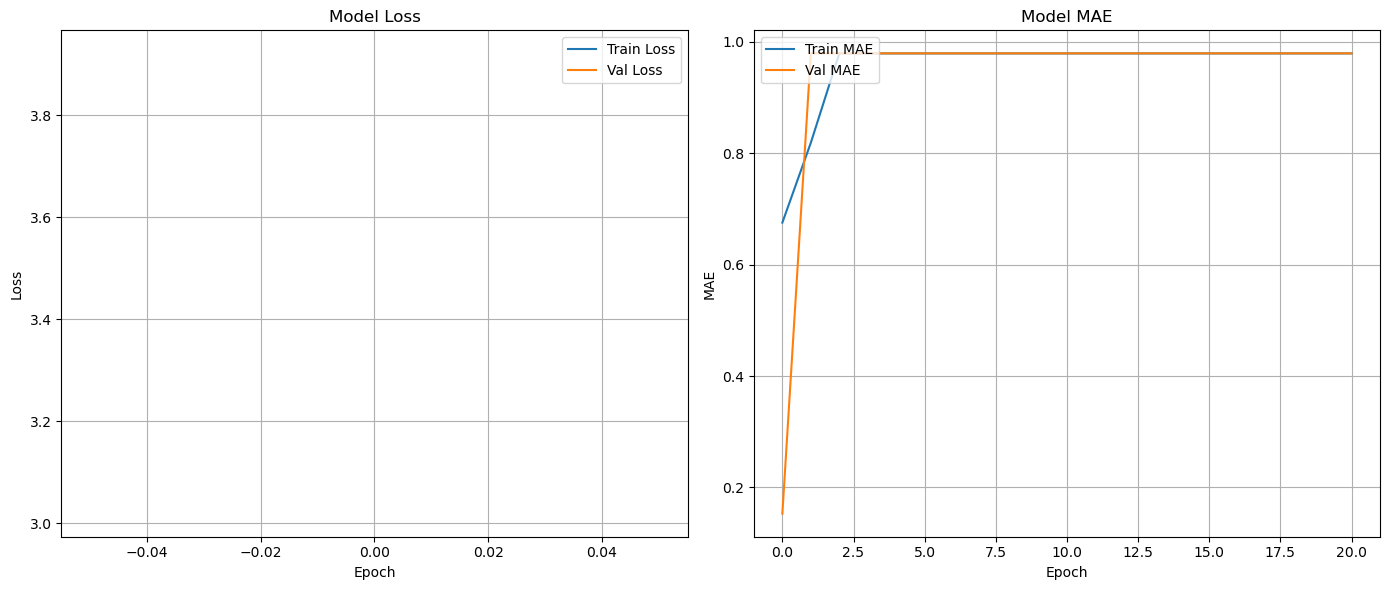

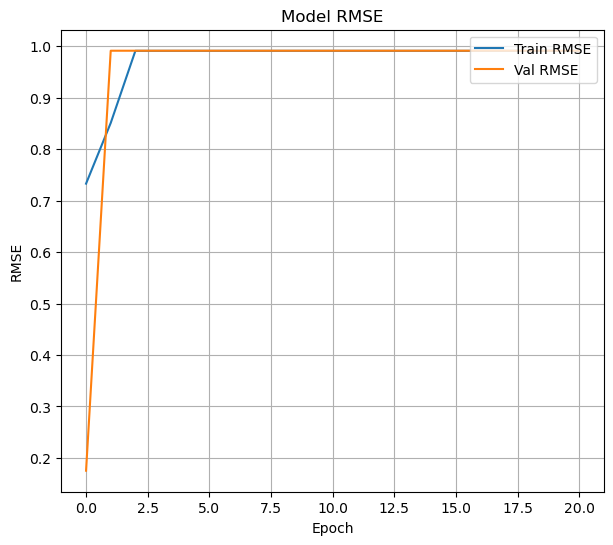

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

# MAE Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot training & validation RMSE
plt.figure(figsize=(7, 6))

# RMSE Plot
plt.plot(history.history['rmse'], label='Train RMSE')
plt.plot(history.history['val_rmse'], label='Val RMSE')
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()


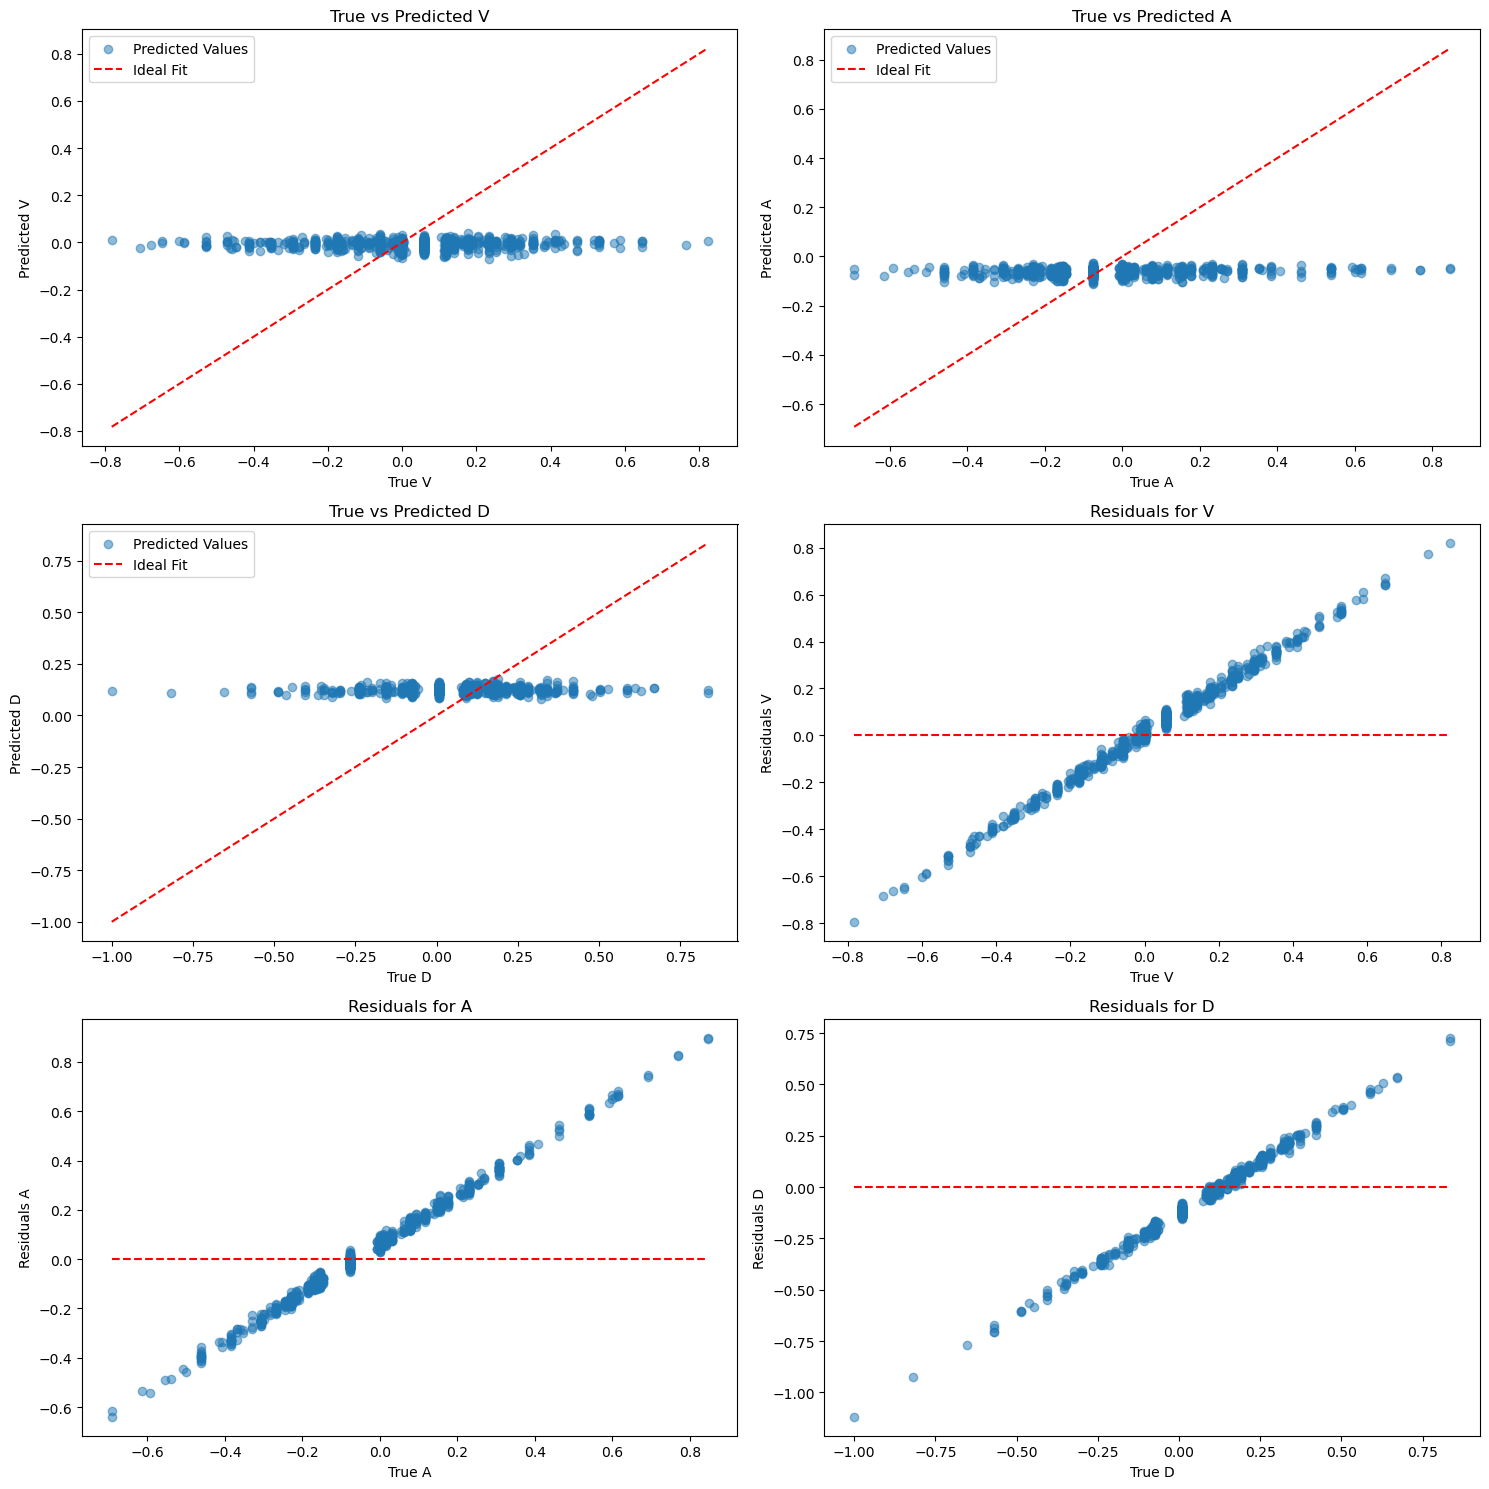

In [12]:
# Calculate residuals
residuals = y_test - y_test_pred

# Plot True Values vs Predictions
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()
targets = ["V", "A", "D"]

for i, target in enumerate(targets):
    # True vs Predicted Values
    axes[i].scatter(y_test[:, i], y_test_pred[:, i], alpha=0.5, label='Predicted Values')
    axes[i].plot([min(y_test[:, i]), max(y_test[:, i])], [min(y_test[:, i]), max(y_test[:, i])], 'r--', label='Ideal Fit')
    axes[i].set_xlabel(f'True {target}')
    axes[i].set_ylabel(f'Predicted {target}')
    axes[i].set_title(f'True vs Predicted {target}')
    axes[i].legend()

for i, target in enumerate(targets):
    # Residuals Plot
    axes[i + 3].scatter(y_test[:, i], residuals[:, i], alpha=0.5)
    axes[i + 3].hlines(0, min(y_test[:, i]), max(y_test[:, i]), colors='r', linestyles='dashed')
    axes[i + 3].set_xlabel(f'True {target}')
    axes[i + 3].set_ylabel(f'Residuals {target}')
    axes[i + 3].set_title(f'Residuals for {target}')

plt.tight_layout()
plt.show()

In [13]:
# Create DataFrames for each dataset and target variable
for i, target in enumerate(["V", "A", "D"]):
    df_train = pd.DataFrame({
        'Text': x_train.values,
        f'True_{target}': y_train[:, i],
        f'Predicted_{target}': y_train_pred[:, i]
    })
    df_val = pd.DataFrame({
        'Text': x_val.values,
        f'True_{target}': y_val[:, i],
        f'Predicted_{target}': y_val_pred[:, i]
    })
    df_test = pd.DataFrame({
        'Text': x_test.values,
        f'True_{target}': y_test[:, i],
        f'Predicted_{target}': y_test_pred[:, i]
    })


    print(f"\nSample DataFrame for train set, target variable {target}:")
    print(df_train.head())

    print(f"\nSample DataFrame for validation set, target variable {target}:")
    print(df_val.head())

    print(f"\nSample DataFrame for test set, target variable {target}:")
    print(df_test.head())


Sample DataFrame for train set, target variable V:
                                                Text    True_V  Predicted_V
0                                    asean talks end  0.058824    -0.003120
1                 antibiotic ketek dangerous thought -0.235294     0.006165
2                  death throughout death everywhere -0.352941     0.010397
3  fascinating collection artifacts pertaining sh...  0.388235    -0.027088
4  rat pack originally frank sinatra dean martin ...  0.058824    -0.020200

Sample DataFrame for validation set, target variable V:
                                                Text        True_V  \
0                                   could free tasha  1.176471e-01   
1  differences western native perceptions lead co...  2.220446e-16   
2                 going shed little blood worry none  5.882353e-02   
3              simplicity dress seen mark modern man  1.235294e-01   
4                                          100 house  5.882353e-02   

   Predicted_V

In [14]:
# Save DataFrames to CSV files
df_train.to_csv(f'train_{target}_comparison_lstm_VAD_norm_tnsf.csv', index=False)
df_val.to_csv(f'val_{target}_comparison_lstm_VAD_norm_tnsf.csv', index=False)
df_test.to_csv(f'test_{target}_comparison_lstm_VAD_norm_tnsf.csv', index=False)